In [28]:
import numpy as np
from pathlib import Path
import librosa
from evaluate import get_metrics
from vad_utils import prediction_to_vad_label
from vad_utils import read_label_from_file
from rich.progress import track
from tqdm import tqdm
from audio_file_process import process_audio_file_traning


# Parameters setting
- The frame size(time) /s
- The frame shift(time) /s
- The number of subbands
- Take smooth or not
- Smooth method
- Take pre_emphasis or not
- Alpha in pre_emphasis

In [29]:
frame_size = float(0.128)
frame_shift = float(0.032)
num_subbands = int(6)
smooth = bool(1)
smooth_type = str('medfilt')
pre_emphasis = bool(1)
alpha = float(0.97)
sampling_rate = int(16000)
frame_length = int(sampling_rate * frame_size)
frame_step = int(sampling_rate * frame_shift)

# Obtain the labels of training data
**注意，这里可能是测试的version**

In [30]:
train_audio_dir = Path('../vad/wavs/dev')
train_label_path = '../vad/data/dev_label.txt'

labels_dict = read_label_from_file(train_label_path, frame_size, frame_shift)

In [ ]:
all_energies = []
all_zcr = []
all_freq_centers = []
all_f0 = []
all_labels = []
all_subband_energies = np.empty((num_subbands, ), dtype=object)

for i in range(num_subbands):
    all_subband_energies[i] = []

audio_files = list(train_audio_dir.glob("*.wav"))

for audio_file in tqdm(audio_files, desc="Processing audio files", unit="file"):
    features, labels = process_audio_file_traning(label_dict=labels_dict, audio_path=str(audio_file), 
                                        frame_length=frame_length, frame_step=frame_step, 
                                        num_subbands=num_subbands, alpha=alpha, 
                                        smooth=smooth, sampling_rate=sampling_rate, 
                                        smooth_type=smooth_type, window='hanning')

    if len(labels) > 0:
        all_energies.extend(features['energies'])
        all_freq_centers.extend(features['freq_centers'])
        all_zcr.extend(features['zcrs'])
        for i in range(num_subbands):
            all_subband_energies[i].extend(features['subband_energies'][i])
        all_f0.extend(features['f0'])
        all_labels.extend(labels)

print(len(all_energies))
print(all_subband_energies.shape)
print(len(all_zcr))
print(len(all_f0))
print(len(all_freq_centers))
print(len(all_labels))

Processing audio files: 100%|██████████| 500/500 [32:43<00:00,  3.93s/file]

218249
(6,)
218249
218249
218249
218249


# Save the features

In [32]:
X = [all_energies, all_zcr, all_freq_centers, all_f0]
for i in range(num_subbands):
    X.append(all_subband_energies[i])

X = np.array(X).T
y = np.array(all_labels)

In [33]:
np.save('features/length_{}_step_{}.npy'.format(frame_length, frame_step), X)

# Data processing
- Considering std
- Dropping the NaNs

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC


clf = LinearSVC(C=1, verbose=2)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

auc, eer = get_metrics(prediction=y_pred, label=y_test)
print(auc, eer)


# Test

In [ ]:
import matplotlib.pyplot as plt

audio_path = '../vad/wavs/dev/54-121080-0009.wav'
audio_key = Path(audio_path).stem

feature, label = process_audio_file_traning(label_dict=labels_dict, audio_path=str(audio_path), 
                                        num_subbands=num_subbands, alpha=alpha, 
                                        frame_length=frame_length, frame_step=frame_step, 
                                        smooth=smooth, smooth_type=smooth_type, window='hann')

energies = []
freq_centers = []
zcr = []
f0 = []
subband_energies = np.empty((num_subbands, ), dtype=object)

for i in range(num_subbands):
    subband_energies[i] = []


if len(label) > 0:
    energies.extend(feature['energies'])
    freq_centers.extend(feature['freq_centers'])
    zcr.extend(feature['zcrs'])
    for i in range(num_subbands):
        subband_energies[i].extend(feature['subband_energies'][i])
    f0.extend(feature['f0'])

x = [energies, zcr, freq_centers, f0]
for i in range(num_subbands):
    x.append(subband_energies[i])

x = np.array(x).T

x = imputer.fit_transform(x)

pred = clf.predict(x)


In [37]:
def deframe(x_framed, win_len, hop_len):
    '''
        interpolates 1D data with framed alignments into persample values.
        This function helps as a visual aid and can also be used to change 
        frame-rate for features, e.g. energy, zero-crossing, etc.
        '''
    n_frames = len(x_framed)
    n_samples = n_frames*hop_len + win_len
    x_samples = np.zeros((n_samples,1))
    for i in range(n_frames):
        x_samples[i*hop_len : i*hop_len + win_len] = x_framed[i]
    return x_samples


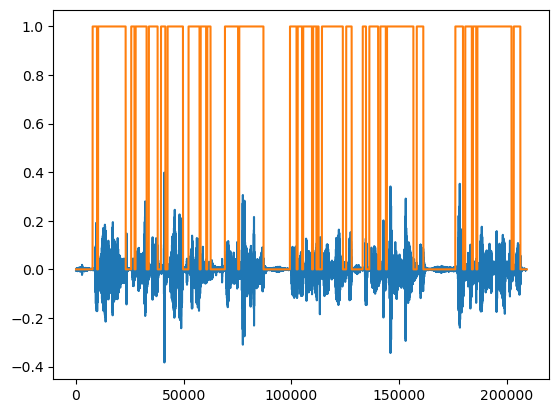

In [38]:
audio, sampling_rate = librosa.load(audio_path, sr = None, )

plt.plot(audio)
s = deframe(pred, frame_length, frame_step)
plt.plot(s)

In [ ]:
import h5py
import numpy as np

params = {'frame_size': frame_size, 'frame_shift': frame_shift, 'num_subbands':num_subbands, 
          'smooth':smooth, 'smooth_type':smooth_type, 'pre_emphasis':pre_emphasis, 'alpha':alpha}

with h5py.File('features/f{}_f{}_n{}_s{}_s{}_p{}_a{}'.format(frame_size, frame_shift, num_subbands, 
                                                             smooth, smooth_type, pre_emphasis, alpha), 'w') as f:
    f.create_dataset('features', data=X)

    for key, value in params.items():
        f.attrs[key] = value

In [ ]:
with h5py.File('features/f{}_f{}_n{}_s{}_s{}_p{}_a{}'.format(frame_size, frame_shift, num_subbands, 
                                                             smooth, smooth_type, pre_emphasis, alpha), 'r') as f:
    features = f['features'][:]
    params = {key: f.attrs[key] for key in f.attrs}

print("Features:", features)
print("Params:", params)